# COVID-19 Vaccine Twitter Preprocessing and Training Data Development

## Contents
1. [Imports](#1.-Imports)
2. [Load Clean Data](#2.-Load-Clean-Data)
3. [Text Preprocessing](#3.-Text-Preprocessing)
4. [Sample Data](#4.-Sample-Data)
    * [4.1 Baseline Accuracy](#4.1-Baseline-Accuracy)
    * [4.2 Train-Test-Split](#4.2-Train-Test-Split)
5. [Base Models - CountVect and TF-IDF](#5.-Base-Models---CountVect-and-TF-IDF)    
    * [5.1 CountVect - Ngrams & Stopwords](#5.1-CountVect---Ngrams-&-Stopwords)
        * [5.1.1 CountVect - Unigram](#5.1.1-CountVect---Unigram)
        * [5.1.2 CountVect - Bigram and Trigram](#5.1.2-CountVect---Bigram-and-Trigram)
    * [5.2 TF-IDF - Ngrams & Stopwords](#5.2-TF-IDF---Ngrams-&-Stopwords)
    * [5.3 Comparing CountVec and TF-IDF](#5.3-Comparing-CountVec-and-TF-IDF)
6. [Initial Model with Extracted TF-IDF Features](#6.-Initial-Model-with-Extracted-TF-IDF-Features)
    * [6.1 Features Exploration](#6.1-Features-Exploration)
    * [6.2 Influential Terms](#6.2-Influential-Terms)
7. [Algorithms Comparison](#7.-Algorithms-Comparison)
8. [Save Preprocessed Data](#8.-Save-Preprocessed-Data)

## 1. Imports

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import itertools
import shap
import eli5
import nltk
import contractions
from bs4 import BeautifulSoup
from collections import Counter
from math import log
import kds
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.metrics import classification_report,confusion_matrix,make_scorer,accuracy_score,precision_score,recall_score,f1_score,roc_curve,auc,fbeta_score,log_loss
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from string import punctuation
# from tortus import Tortus
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Load Clean Data

In [3]:
# Load the cleaned data: 'covidvaccine_cleaned.csv'
df = pd.read_csv('../data/covidvaccine_cleaned.csv')

In [4]:
df.shape

(135322, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135322 entries, 0 to 135321
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         135322 non-null  object 
 1   user_location     107141 non-null  object 
 2   user_description  128259 non-null  object 
 3   user_created      135322 non-null  object 
 4   user_followers    135322 non-null  float64
 5   user_friends      135322 non-null  float64
 6   user_favourites   135322 non-null  float64
 7   user_verified     135322 non-null  bool   
 8   date              135322 non-null  object 
 9   text              135322 non-null  object 
 10  hashtags          135322 non-null  object 
 11  source            133108 non-null  object 
 12  is_retweet        135322 non-null  bool   
 13  clean_hashtags    135322 non-null  object 
 14  clean_text        135322 non-null  object 
dtypes: bool(2), float64(3), object(10)
memory usage: 13.7+ MB


In [6]:
# Set 'date' and 'user_created' columns as Datetime
df['date'] = pd.to_datetime(df.date)
df['user_created'] = pd.to_datetime(df.user_created)

In [7]:
df.dtypes

user_name                   object
user_location               object
user_description            object
user_created        datetime64[ns]
user_followers             float64
user_friends               float64
user_favourites            float64
user_verified                 bool
date                datetime64[ns]
text                        object
hashtags                    object
source                      object
is_retweet                    bool
clean_hashtags              object
clean_text                  object
dtype: object

## 3. Text Preprocessing

Text data is known to be unstructured data. Thus, it is important to clean/preprocess our tweets in order to standarize textual form. These are our preprocessing steps:

1. HTML decoding - HTML encodings will be decoded into standard english characters
2. Removing @mentions(twitter handles) and URL links
3. Expand contractions  - Examples: I'm --> I am , she's --> she is , shouldn't --> should not , can't --> cannot
4. Lower-casing
5. Removing numbers and special characters
6. Tokenization
7. Lemmatization

***

- **Note:** We will not be removing stopwords at this time. We will run some experiments to see if whether including or removing stopwords performs better.

***

In [8]:
tokenizer =  TweetTokenizer()
lemmatizer = WordNetLemmatizer()

def tweet_cleanser(text):
    html_raw = BeautifulSoup(text,'lxml')
    # html_raw = BeautifulSoup(text,'html.parser')
    html_text = html_raw.get_text()
    try:
        html_decoder = html_text.decode('utf-8-sig').replace(u'\ufffd','?')
    except:
        html_decoder = html_text
    strip_mentions = re.sub(r'@[A-Za-z0-9_]+','',html_decoder)
    strip_https = re.sub(r'|'.join((r'www.[^ ]+',r'https?://[^ ]+')),'',strip_mentions)
    expansion = contractions.fix(strip_https)
    lower_case = expansion.lower()
    letters_only = re.sub('[^a-zA-Z]',' ',lower_case)
    token = tokenizer.tokenize(letters_only)
    lem = [lemmatizer.lemmatize(x) for x in token]
    return ' '.join(lem).strip()

In [9]:
df['clean_tweets'] = df.text.apply(tweet_cleanser)

In [10]:
# Check for duplicates
df[df.duplicated(['clean_tweets'],keep=False)].sort_values('clean_tweets')

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text,clean_tweets
29523,"Stephen Cico, MD MEd",@iumedschool in Indianapolis,"Asst Dean, Assoc Prof & Fellowship Dir of #Ped...",2015-02-12 17:57:00,305.0,1.0,99.0,True,2021-01-09 20:01:00,As a #FrontLine #EmergencyPhysician #Emergency...,"['FrontLine', 'EmergencyPhysician', 'Emergency...",Twitter for iPhone,False,"frontline, emergencyphysician, emergencymedici...",as a frontline emergencyphysician emergencymed...,a a frontline emergencyphysician emergencymedi...
29527,Stevie & Lane,Meridian-Kessler~Indianapolis,Our adventure has taken us fr Music City to th...,2009-12-24 04:44:00,107.0,0.0,205.0,True,2021-01-09 20:02:00,As a #FrontLine #EmergencyPhysician #Emergency...,"['FrontLine', 'EmergencyPhysician', 'Emergency...",Twitter for iPhone,False,"frontline, emergencyphysician, emergencymedici...",as a frontline emergencyphysician emergencymed...,a a frontline emergencyphysician emergencymedi...
15763,Covid India Seva,India,Official @MoHFW_INDIA Handle for COVID-19 Resp...,2020-03-26 17:27:00,41371.0,21.0,455.0,True,2020-12-26 09:04:00,As a step to prep up for the administration of...,['CovidVaccine'],Twitter Web App,False,covidvaccine,as a step to prep up for the administration of...,a a step to prep up for the administration of ...
15742,Covid India Seva,India,Official @MoHFW_INDIA Handle for COVID-19 Resp...,2020-03-26 17:27:00,41371.0,21.0,455.0,True,2020-12-26 06:05:00,As a step to prep up for the administration of...,['CovidVaccine'],Twitter Web App,False,covidvaccine,as a step to prep up for the administration of...,a a step to prep up for the administration of ...
12706,Geoffrey Riesel,London,"Leadership, Motivation, Negotiation Change Man...",2010-02-17 14:45:00,1904.0,2445.0,2568.0,True,2020-11-18 13:25:00,"As a 70 yr old with serious health issues, I f...",['CovidVaccine'],Twitter for iPhone,False,covidvaccine,as a 70 yr old with serious health issues i fo...,a a yr old with serious health issue i for one...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15774,GunGamezzz,NaN,🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝↘️↘️🚨Watch My ...,2020-04-14 01:32:00,1.0,0.0,37.0,True,2020-12-26 09:27:00,YouTube: Gun Gamezzz #COVID19 #covid #COVID19V...,"['COVID19', 'covid', 'COVID19Vaccine', 'CovidV...",Twitter for iPhone,False,"covid19, covid, covid19vaccine, covidvaccine, ...",youtube gun gamezzz covid19 covid covid19vacci...,youtube gun gamezzz covid covid covid vaccine ...
15775,GunGamezzz,NaN,🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝↘️↘️🚨Watch My ...,2020-04-14 01:32:00,1.0,0.0,37.0,True,2020-12-26 09:28:00,YouTube: Gun Gamezzz #COVID19 #covid #COVID19V...,"['COVID19', 'covid', 'COVID19Vaccine', 'CovidV...",Twitter for iPhone,False,"covid19, covid, covid19vaccine, covidvaccine, ...",youtube gun gamezzz covid19 covid covid19vacci...,youtube gun gamezzz covid covid covid vaccine ...
15776,GunGamezzz,NaN,🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝↘️↘️🚨Watch My ...,2020-04-14 01:32:00,1.0,0.0,37.0,True,2020-12-26 09:28:00,YouTube: Gun Gamezzz #COVID19 #covid #COVID19V...,"['COVID19', 'covid', 'COVID19Vaccine', 'CovidV...",Twitter for iPhone,False,"covid19, covid, covid19vaccine, covidvaccine, ...",youtube gun gamezzz covid19 covid covid19vacci...,youtube gun gamezzz covid covid covid vaccine ...
15767,GunGamezzz,NaN,🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝↘️↘️🚨Watch My ...,2020-04-14 01:32:00,1.0,0.0,37.0,True,2020-12-26 09:21:00,YouTube: Gun Gamezzz #COVID19 #covid #COVID19V...,"['COVID19', 'covid', 'COVID19Vaccine', 'CovidV...",Twitter for iPhone,False,"covid19, covid, covid19vaccine, covidvaccine, ...",youtube gun gamezzz covid19 covid covid19vacci...,youtube gun gamezzz covid covid covid vaccine ...


***

- **Note:** After the updating the preprocessing/data cleaning step in this notebook, we found more duplicates. We will keep only the first occurrence of every duplicate and then drop the rest.

***

In [11]:
# Drop dupes
df.drop_duplicates(['clean_tweets'],keep='first',inplace=True)

# Recheck for dupes
df[df.duplicated(['clean_tweets'],keep=False)]

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text,clean_tweets


In [12]:
df.shape

(124427, 16)

## 4. Sample Data

In [13]:
# # df.sample(n=1000,random_state=2).to_csv('../data/1000factopinion.csv',index=False)

# df1000 = pd.read_csv('../data/1000factopinion.csv')

# # # Anotate 1000 tweets

# # tortus = Tortus(df1000,'text',num_records=1000,id_column=None,annotations=None,random=False,labels=['Fact/Announcement','Opinion'])
# # tortus.annotate()
# # annotations = tortus.annotations

# # # Combine Annotations, Drop columns, Save annotated dataframe

# # df1000_merged = pd.merge(df1000,annotations,on='text',how='inner')
# # df1000_merged.drop(['id_column','annotated_at'],axis=1,inplace=True)
# # df1000_merged['classes'] = df1000_merged['label'].apply(lambda x:0 if x=='fact/announcement' else 1)
# # df1000_merged.to_csv('../data/1000factopinion_annot_2.csv',index=False)

# df_factop1k = pd.read_csv('../data/1000factopinion_annot_2.csv')
# factop1k_cleaned = df_factop1k[['clean_tweets','label','classes']]
# # factop1k_cleaned.to_csv('../data/1000factopinion_annot_2_cleaned.csv',index=False)

# # print(factop1k_cleaned['label'].value_counts())

# factop1k_cleaned.head(15)

# factop1k_counts = pd.DataFrame([factop1k_cleaned['label'].value_counts(),factop1k_cleaned['label'].value_counts(normalize=True)]).T
# factop1k_counts.columns = ['count','%']

# print("Baseline Accuracy = %0.2f %%"%np.round(factop1k_counts['%'].max()*100,2))

# factop1k_counts

In [14]:
# df.sample(n=1000, random_state=2).to_csv('../data/1000k.csv',index=False)

In [15]:
df_sample = pd.read_csv('../data/1000k.csv')

In [16]:
df_sample[df_sample.duplicated(['clean_tweets'],keep=False)]

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text,clean_tweets


In [17]:
df_sample.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text,clean_tweets
0,Charzen,NaN,Only the development of compassion and underst...,2013-04-14 17:28:00,740.0,1681.0,88467.0,True,2020-12-31 14:43:00,"Thank you, @hartfordhosp and @HartfordHealthC!...",['CovidVaccine'],Twitter for iPhone,False,covidvaccine,thank you and feeling grateful and hopeful wit...,thank you and feeling grateful and hopeful wit...
1,KalhanRan,Sri Lanka,Presenting The Interesting With Colour & Style,2019-04-30 15:30:00,55.0,10.0,5973.0,True,2021-01-20 05:45:00,"While we wait for clearance , India ships vacc...","['LKA', 'lka', 'SriLanka', 'COVID19SL', 'COVID...",Twitter Web App,False,"lka, lka, srilanka, covid19sl, covid19, covidv...",while we wait for clearance india ships vaccin...,while we wait for clearance india ship vaccine...
2,Elaine Schattner,NYC,Journalist. Physician. Book on cancer attitude...,2009-12-07 20:37:00,18111.0,10492.0,27964.0,True,2021-01-21 14:08:00,"Meanwhile NYC has a #CovidVaccine shortage, is...",['CovidVaccine'],Twitter Web App,False,covidvaccine,meanwhile nyc has a covidvaccine shortage is c...,meanwhile nyc ha a covidvaccine shortage is ca...
3,Gabriel Hackett,"Liverpool, the South end. 🇮🇪",#JUSTSAYNO,2011-04-21 17:57:00,321.0,1605.0,2031.0,False,2021-03-19 20:36:00,@Anshul__K Is this along the lines of what Dr....,['CovidVaccine'],Twitter for Android,False,covidvaccine,is this along the lines of what dr vanden boss...,is this along the line of what dr vanden bossc...
4,The English Post,India,The English Post brings you news from around t...,2016-09-19 17:48:00,4691.0,297.0,1.0,True,2020-10-22 15:01:00,"AstraZeneca Covid volunteer dies, trials to co...","['AstraZeneca', 'CovidVaccine']",Twitter Web App,False,"astrazeneca, covidvaccine",astrazeneca covid volunteer dies trials to con...,astrazeneca covid volunteer dy trial to contin...


In [18]:
# # Anotate sample

# tortus = Tortus(df_sample,'text',num_records=1000,id_column=None,annotations=None,random=False,labels=['Negative','Neutral','Positive'])
# tortus.annotate()

In [19]:
# annotations_1000 = tortus.annotations

# # Combine Annotations, Drop columns, Save annotated dataframe

# annotated1k = pd.merge(df_sample,annotations_1000,on='text',how='inner')
# annotated1k.drop(['id_column','annotated_at'],axis=1,inplace=True)
# annotated1k['label'] = annotated1k['label'].apply(lambda x:0 if x=='negative' else 1 if x=='neutral' else 2)
# annotated1k.to_csv('../data/1000_lab6.csv',index=False)

### 4.1 Baseline Accuracy

In [20]:
df_factop1k = pd.read_csv('../data/1000_lab6.csv')
factop1k_cleaned = df_factop1k[['clean_tweets','label','classes','classes2']]
factop1k_cleaned2 = factop1k_cleaned.copy()
factop1k_cleaned2['classes2'] = factop1k_cleaned2['classes2'].replace(3,1)

factop1k_counts1 = pd.DataFrame({'count':factop1k_cleaned2['classes2'].value_counts(),'%':factop1k_cleaned2['classes2'].value_counts(normalize=True)})
base1 = factop1k_counts1['%'].max()

print("Baseline Accuracy = %0.2f %%"%(base1*100))
factop1k_counts1

Baseline Accuracy = 57.90 %


,count,%
1,579,0.579
2,324,0.324
0,97,0.097


In [21]:
# value_counts = pd.DataFrame([df1000['label2'].value_counts(),df1000['label2'].value_counts(normalize=True)]).T
# value_counts.columns = ['count','%']
# # value_counts.index = ['Neutral','Positive','Negative']
# value_counts

In [22]:
# Determining a baseline accuracy
zero_rate1 = 0.579

print("Zero-Rate Classifer Accuracy (Baseline Accuracy) = %0.2f %%"%np.round(zero_rate1*100,2))
# print("Voting-Based Accuracy = %0.2f %%"%np.round(voting_accuracy*100,2))

Zero-Rate Classifer Accuracy (Baseline Accuracy) = 57.90 %


***

- **Note:** ZeroR Classifier predicts the most-frequent class which is the proportion of the majority class. Hence, since the Neutral class is the largest class in our sample, the ZeroR accuracy would be 57.9% if we had predicted Neutral for every outcome. We aim to achieve an accuracy better than the ZeroR value to demonstrate that our model is useful at prediction and has skill on our target problem.

***

### 4.2 Train-Test-Split

In [23]:
X1 = factop1k_cleaned2.clean_tweets
y1 = factop1k_cleaned2.classes2

corpus_train1,corpus_test1,y_train1,y_test1 = train_test_split(X1,y1,test_size=0.3,random_state=3)

In [24]:
labels = ['Negative','Neutral','Positive']

# Function to plot confusion matrix
def confusion_mat(y_test,y_pred,labels):
    cm = confusion_matrix(y_test,y_pred)
    cm_normalize = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    fig,ax = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(cm, annot=True,fmt='g',cmap='Blues',ax=ax[0])
    sns.heatmap(cm_normalize,annot=True,fmt='.2',cmap='Blues',ax=ax[1])

    # labels, title, xticks, yticks
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label') 
    ax[0].set_title('Confusion Matrix, without normalization')
    ax[0].xaxis.set_ticklabels(labels) 
    ax[0].yaxis.set_ticklabels(labels)
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label') 
    ax[1].set_title('Normalized Confusion Matrix')
    ax[1].xaxis.set_ticklabels(labels) 
    ax[1].yaxis.set_ticklabels(labels)
    plt.tight_layout()
    plt.show(); 

## 5. Base Models - CountVect and TF-IDF

CountVect - LOGREG BASELINE MODEL

              precision    recall  f1-score   support

    Negative       0.44      0.17      0.24        24
     Neutral       0.79      0.91      0.84       185
    Positive       0.81      0.69      0.75        91

    accuracy                           0.78       300
   macro avg       0.68      0.59      0.61       300
weighted avg       0.77      0.78      0.77       300



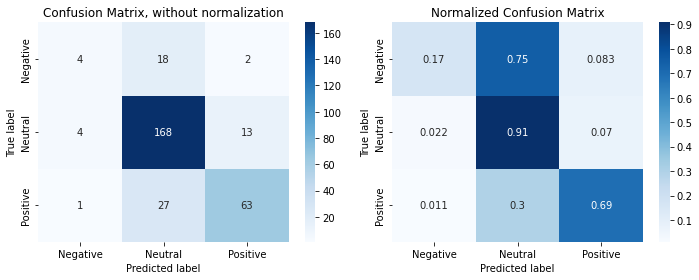


TfidfVect - LOGREG BASELINE MODEL

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.77      0.97      0.86       185
    Positive       0.90      0.66      0.76        91

    accuracy                           0.80       300
   macro avg       0.56      0.54      0.54       300
weighted avg       0.75      0.80      0.76       300



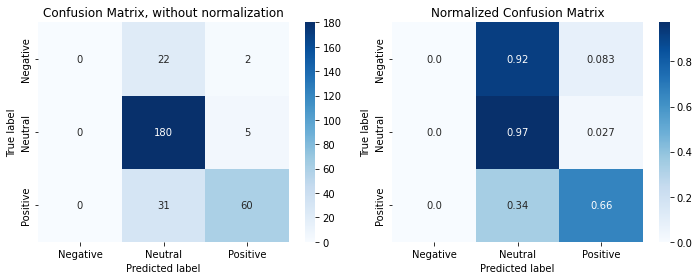

In [25]:
print('CountVect - LOGREG BASELINE MODEL\n')
cvec = CountVectorizer()

X_train_cvec_base = cvec.fit_transform(corpus_train1)
X_test_cvec_base = cvec.transform(corpus_test1)

cvec_lr_base = LogisticRegression()
cvec_lr_base.fit(X_train_cvec_base,y_train1)

y_pred_cvec_base = cvec_lr_base.predict(X_test_cvec_base)

print(classification_report(y_test1,y_pred_cvec_base,target_names=labels))
confusion_mat(y_test1,y_pred_cvec_base,labels)

print('\nTfidfVect - LOGREG BASELINE MODEL\n')
tfidf = TfidfVectorizer()

X_train_tfidf_base = tfidf.fit_transform(corpus_train1)
X_test_tfidf_base = tfidf.transform(corpus_test1)

tfidf_lr_base = LogisticRegression()
tfidf_lr_base.fit(X_train_tfidf_base,y_train1)

y_pred_tfidf_base = tfidf_lr_base.predict(X_test_tfidf_base)

print(classification_report(y_test1,y_pred_tfidf_base,target_names=labels))
confusion_mat(y_test1,y_pred_tfidf_base,labels)

### 5.1 CountVect - Ngrams & Stopwords

In [26]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(100,2550,200)

In [27]:
def accuracy_report(pipeline,corpus_train1,corpus_test1,y_train1,y_test1):
    pipe_fit = pipeline.fit(corpus_train1,y_train1)
    y_pred1 = pipe_fit.predict(corpus_test1)
    acc_score = accuracy_score(y_test1,y_pred1)
    print('Accuracy Score: {0:.2f}%'.format(acc_score*100))
    return acc_score

def nfeature_accuracy_report(vectorizer=cvec,classifier=lr,n_features=n_features,ngram_range=(1,1),stop_words=None):
    res = []
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words,max_features=n,ngram_range=ngram_range)
        pipeline = Pipeline([('vectorizer',vectorizer),('classifier',classifier)])
        print('Result for {} features'.format(n))
        nfeature_acc_score = accuracy_report(pipeline,corpus_train1,corpus_test1,y_train1,y_test1)
        res.append((n,nfeature_acc_score))
    return res

def plot_ngrams(v,plots_name,plots_list,plots_dict):
    for n,m in zip(plots_name,range(len(plots_list))):
        if v=='cvec':
            plots_dict["cvec_{}".format(n)] = pd.DataFrame(plots_list[m]).rename(columns={0:'nfeats',1:'valid_acc'})
            plots_dict["cvec_{}".format(n)].insert(0,'alg',n)
        else:
            plots_dict["tfidf_{}".format(n)] = pd.DataFrame(plots_list[m]).rename(columns={0:'nfeats',1:'valid_acc'}) 
            plots_dict["tfidf_{}".format(n)].insert(0,'alg',n)

plots_dict1,plots_dict2,plots_dict3,plots_dict4a,plots_dict4b,plots_dict5 = [dict() for _ in range(6)]

### 5.1.1 CountVect - Unigram

COUNTVEC-UNIGRAM WITH STOP WORDS

Result for 100 features
Accuracy Score: 71.67%
Result for 300 features
Accuracy Score: 74.33%
Result for 500 features
Accuracy Score: 75.67%
Result for 700 features
Accuracy Score: 75.00%
Result for 900 features
Accuracy Score: 75.00%
Result for 1100 features
Accuracy Score: 75.00%
Result for 1300 features
Accuracy Score: 76.33%
Result for 1500 features
Accuracy Score: 75.67%
Result for 1700 features
Accuracy Score: 76.00%
Result for 1900 features
Accuracy Score: 75.67%
Result for 2100 features
Accuracy Score: 76.33%
Result for 2300 features
Accuracy Score: 78.00%
Result for 2500 features
Accuracy Score: 78.00%

COUNTVEC-UNIGRAM REMOVING STOP WORDS

Result for 100 features
Accuracy Score: 71.33%
Result for 300 features
Accuracy Score: 72.00%
Result for 500 features
Accuracy Score: 71.33%
Result for 700 features
Accuracy Score: 73.33%
Result for 900 features
Accuracy Score: 73.33%
Result for 1100 features
Accuracy Score: 73.33%
Result for 1300 features


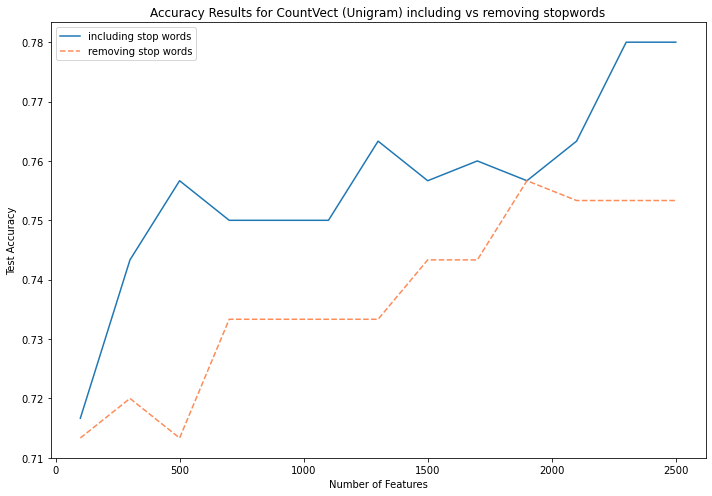

In [28]:
print("COUNTVEC-UNIGRAM WITH STOP WORDS\n")
cvec_uni_stop = nfeature_accuracy_report()
print("\nCOUNTVEC-UNIGRAM REMOVING STOP WORDS\n")
cvec_uni_nostop = nfeature_accuracy_report(stop_words='english')

plots_name1 = ['including stop words','removing stop words']
plots_list1 = [cvec_uni_stop,cvec_uni_nostop]
plot_ngrams('cvec',plots_name1,plots_list1,plots_dict1)

df_plots1a = pd.concat([plots_dict1['cvec_including stop words']],ignore_index=True)
df_plots1b = pd.concat([plots_dict1['cvec_removing stop words']],ignore_index=True)

plt.figure(figsize=(10,7))
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots1a)
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots1b,linestyle='--',palette='OrRd')
plt.title("Accuracy Results for CountVect (Unigram) including vs removing stopwords")
plt.xlabel("Number of Features"); plt.ylabel("Test Accuracy")
leg = plt.legend().get_lines()
leg[1].set_linestyle("--")
plt.tight_layout();

***

- **Note:** CountVec performs better when we do not remove stopwords. Let's check if including stopwords is ideal at bigrams and trigrams for countvec.

***

### 5.1.2 CountVect - Bigram and Trigram

COUNTVEC-BIGRAM WITH STOP WORDS

Result for 100 features
Accuracy Score: 69.33%
Result for 300 features
Accuracy Score: 74.00%
Result for 500 features
Accuracy Score: 74.00%
Result for 700 features
Accuracy Score: 75.67%
Result for 900 features
Accuracy Score: 75.33%
Result for 1100 features
Accuracy Score: 75.67%
Result for 1300 features
Accuracy Score: 74.33%
Result for 1500 features
Accuracy Score: 74.00%
Result for 1700 features
Accuracy Score: 73.67%
Result for 1900 features
Accuracy Score: 74.00%
Result for 2100 features
Accuracy Score: 74.33%
Result for 2300 features
Accuracy Score: 74.00%
Result for 2500 features
Accuracy Score: 75.00%

COUNTVEC-BIGRAM REMOVING STOP WORDS

Result for 100 features
Accuracy Score: 70.00%
Result for 300 features
Accuracy Score: 71.67%
Result for 500 features
Accuracy Score: 72.00%
Result for 700 features
Accuracy Score: 72.33%
Result for 900 features
Accuracy Score: 71.67%
Result for 1100 features
Accuracy Score: 72.33%
Result for 1300 features
Ac

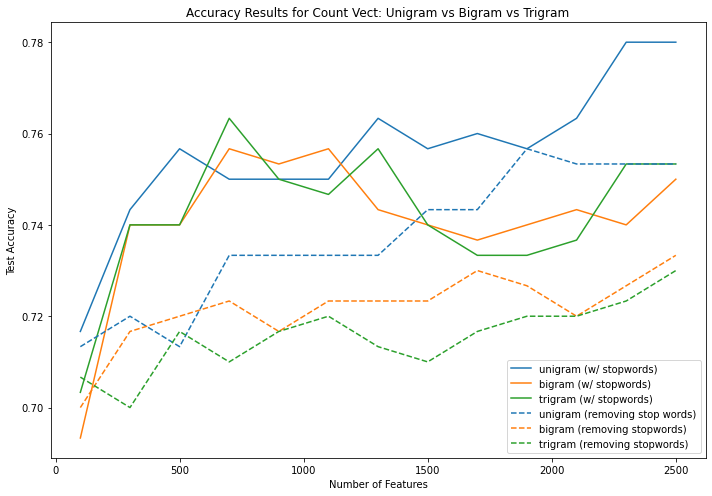

In [29]:
print("COUNTVEC-BIGRAM WITH STOP WORDS\n")
cvec_bi_stop = nfeature_accuracy_report(ngram_range=(1,2))
print("\nCOUNTVEC-BIGRAM REMOVING STOP WORDS\n")
cvec_bi_nostop = nfeature_accuracy_report(stop_words='english',ngram_range=(1,2))
print("\nCOUNTVEC-TRIGRAM WITH STOP WORDS\n")
cvec_tri_stop = nfeature_accuracy_report(ngram_range=(1,3))
print("\nCOUNTVEC-TRIGRAM REMOVING STOP WORDS\n")
cvec_tri_nostop = nfeature_accuracy_report(stop_words='english',ngram_range=(1,3))

plots_name2 = ['unigram (w/ stopwords)','unigram (removing stop words)','bigram (w/ stopwords)','bigram (removing stopwords)','trigram (w/ stopwords)','trigram (removing stopwords)']
plots_list2 = [cvec_uni_stop,cvec_uni_nostop,cvec_bi_stop,cvec_bi_nostop,cvec_tri_stop,cvec_tri_nostop]
plot_ngrams('cvec',plots_name2,plots_list2,plots_dict2)

df_plots2a = pd.concat([plots_dict2['cvec_unigram (w/ stopwords)'],plots_dict2['cvec_bigram (w/ stopwords)'],plots_dict2['cvec_trigram (w/ stopwords)']],ignore_index=True)
df_plots2b = pd.concat([plots_dict2['cvec_unigram (removing stop words)'],plots_dict2['cvec_bigram (removing stopwords)'],plots_dict2['cvec_trigram (removing stopwords)']],ignore_index=True)

plt.figure(figsize=(10,7))
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots2a)
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots2b,linestyle='--')
plt.title("Accuracy Results for Count Vect: Unigram vs Bigram vs Trigram")
plt.xlabel("Number of Features"); plt.ylabel("Test Accuracy")
leg = plt.legend().get_lines()
leg[3].set_linestyle("--")
leg[4].set_linestyle("--")
leg[5].set_linestyle("--")
plt.tight_layout();

***

**Note:** For CountVec, it seems that including stop words rather than removing them from text seems to boost models performance for bigrams and unigrams as well. Next, we'll do the same for TF-IDF and then compare both results.

***

### 5.2 TF-IDF - Ngrams & Stopwords

In [30]:
tvec = TfidfVectorizer()


TFIDF-UNIGRAM WITH STOP WORDS

Result for 100 features
Accuracy Score: 75.67%
Result for 300 features
Accuracy Score: 79.00%
Result for 500 features
Accuracy Score: 79.00%
Result for 700 features
Accuracy Score: 80.00%
Result for 900 features
Accuracy Score: 80.33%
Result for 1100 features
Accuracy Score: 80.33%
Result for 1300 features
Accuracy Score: 79.67%
Result for 1500 features
Accuracy Score: 80.00%
Result for 1700 features
Accuracy Score: 80.00%
Result for 1900 features
Accuracy Score: 79.67%
Result for 2100 features
Accuracy Score: 79.67%
Result for 2300 features
Accuracy Score: 80.00%
Result for 2500 features
Accuracy Score: 79.67%

TFIDF-UNIGRAM REMOVING STOP WORDS

Result for 100 features
Accuracy Score: 70.33%
Result for 300 features
Accuracy Score: 74.67%
Result for 500 features
Accuracy Score: 74.33%
Result for 700 features
Accuracy Score: 76.00%
Result for 900 features
Accuracy Score: 76.67%
Result for 1100 features
Accuracy Score: 76.00%
Result for 1300 features
Accur

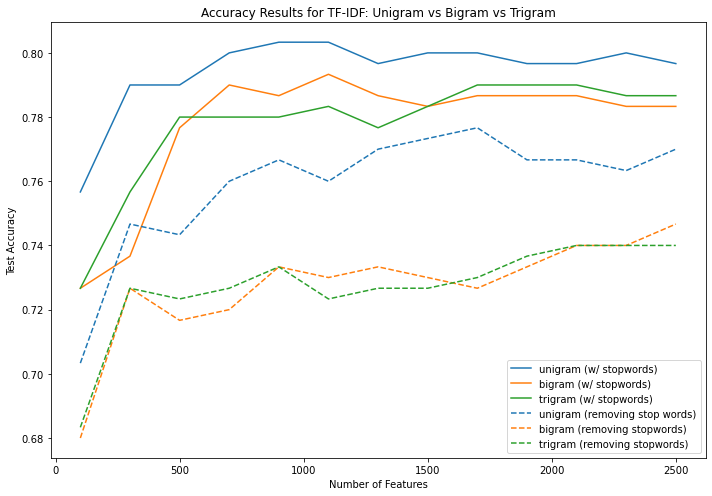

In [31]:
print("\nTFIDF-UNIGRAM WITH STOP WORDS\n")
tfidf_uni_stop = nfeature_accuracy_report(vectorizer=tvec)
print("\nTFIDF-UNIGRAM REMOVING STOP WORDS\n")
tfidf_uni_nostop = nfeature_accuracy_report(vectorizer=tvec,stop_words='english')
print("\nTFIDF-BIGRAM WITH STOP WORDS\n")
tfidf_bi_stop = nfeature_accuracy_report(vectorizer=tvec,ngram_range=(1,2))
print("\nTFIDF-BIGRAM REMOVING STOP WORDS\n")
tfidf_bi_nostop = nfeature_accuracy_report(vectorizer=tvec,ngram_range=(1,2),stop_words='english')
print("\nTFIDF-TRIGRAM WITH STOP WORDS\n")
tfidf_tri_stop = nfeature_accuracy_report(vectorizer=tvec,ngram_range=(1,3))
print("\nTFIDF-TRIGRAM REMOVING STOP WORDS\n")
tfidf_tri_nostop = nfeature_accuracy_report(vectorizer=tvec,ngram_range=(1,3),stop_words='english')

plots_name3 = ['unigram (w/ stopwords)','unigram (removing stop words)','bigram (w/ stopwords)','bigram (removing stopwords)','trigram (w/ stopwords)','trigram (removing stopwords)']
plots_list3 = [tfidf_uni_stop,tfidf_uni_nostop,tfidf_bi_stop,tfidf_bi_nostop,tfidf_tri_stop,tfidf_tri_nostop]
plot_ngrams('tfidf',plots_name3,plots_list3,plots_dict3)

df_plots3a = pd.concat([plots_dict3['tfidf_unigram (w/ stopwords)'],plots_dict3['tfidf_bigram (w/ stopwords)'],plots_dict3['tfidf_trigram (w/ stopwords)']],ignore_index=True)
df_plots3b = pd.concat([plots_dict3['tfidf_unigram (removing stop words)'],plots_dict3['tfidf_bigram (removing stopwords)'],plots_dict3['tfidf_trigram (removing stopwords)']],ignore_index=True)

plt.figure(figsize=(10,7))
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots3a)
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots3b,linestyle='--')
plt.title("Accuracy Results for TF-IDF: Unigram vs Bigram vs Trigram")
plt.xlabel("Number of Features"); plt.ylabel("Test Accuracy")
leg = plt.legend().get_lines()
leg[3].set_linestyle("--")
leg[4].set_linestyle("--")
leg[5].set_linestyle("--")
plt.tight_layout();

***

- **Note:** We see similar findings for TF-IDF as well. Including stopwords seems to improve accuracy at all stages.
    
***

### 5.3 Comparing CountVec and TF-IDF

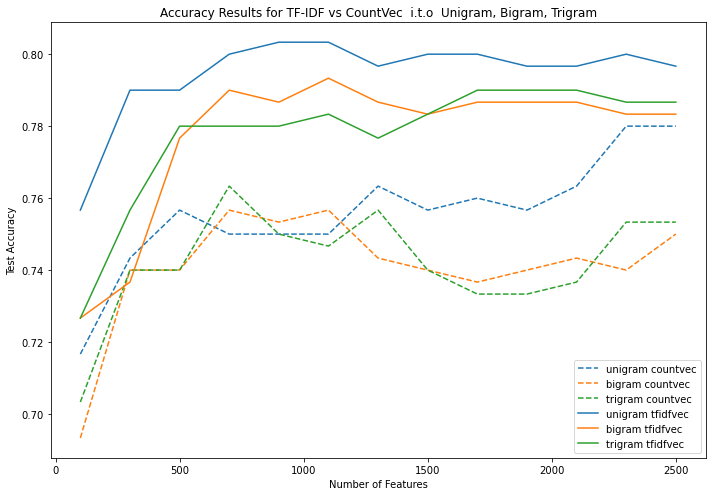

In [32]:
plots_name4a,plots_name4b = ['unigram countvec','bigram countvec','trigram countvec'],['unigram tfidfvec','bigram tfidfvec','trigram tfidfvec']
plots_list4a,plots_list4b = [cvec_uni_stop,cvec_bi_stop,cvec_tri_stop],[tfidf_uni_stop,tfidf_bi_stop,tfidf_tri_stop]
plot_ngrams('cvec',plots_name4a,plots_list4a,plots_dict4a)
plot_ngrams('tfidf',plots_name4b,plots_list4b,plots_dict4b)

df_plots4a = pd.concat([plots_dict4a['cvec_unigram countvec'],plots_dict4a['cvec_bigram countvec'],plots_dict4a['cvec_trigram countvec']],ignore_index=True)
df_plots4b = pd.concat([plots_dict4b['tfidf_unigram tfidfvec'],plots_dict4b['tfidf_bigram tfidfvec'],plots_dict4b['tfidf_trigram tfidfvec']],ignore_index=True)

plt.figure(figsize=(10,7))
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots4a,linestyle='--')
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots4b)
plt.title("Accuracy Results for TF-IDF vs CountVec  i.t.o  Unigram, Bigram, Trigram")
plt.xlabel("Number of Features"); plt.ylabel("Test Accuracy")
leg = plt.legend().get_lines()
leg[0].set_linestyle("--")
leg[1].set_linestyle("--")
leg[2].set_linestyle("--")
plt.tight_layout();
# plt.savefig('../images/tfidf_bow_ngrams.jpg',bbox_inches='tight')

***

- **Note:** Overall, we found that TF-IDF yielded higher performance results than countvec at all stages. TF-IDF  yielded highest validation accuracy of 80.33% with these features:
    - unigrams w/ stopwords at 900 features
    - bigrams w/ stopwords at 1100 features
***

## 6. Initial Model with Extracted TF-IDF Features

TfidfVect - LOGREG MODEL W/ 900 FEATURES & UNIGRAM

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.77      0.97      0.86       185
    Positive       0.91      0.67      0.77        91

    accuracy                           0.80       300
   macro avg       0.56      0.55      0.54       300
weighted avg       0.75      0.80      0.77       300



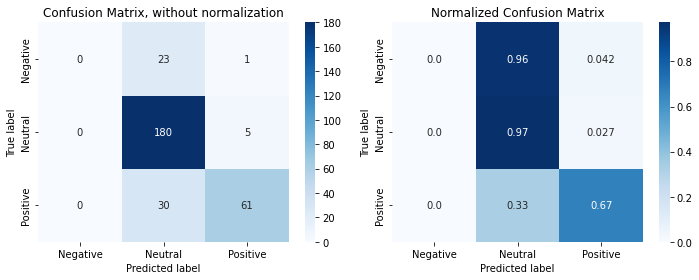


TfidfVect - LOGREG MODEL W/ 1100 FEATURES & UNIGRAM

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.77      0.98      0.86       185
    Positive       0.91      0.66      0.76        91

    accuracy                           0.80       300
   macro avg       0.56      0.55      0.54       300
weighted avg       0.75      0.80      0.76       300



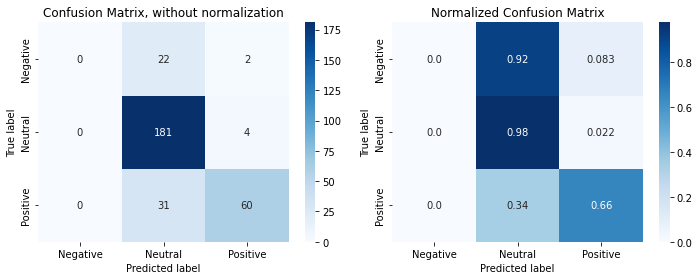

In [33]:
print('TfidfVect - LOGREG MODEL W/ 900 FEATURES & UNIGRAM\n')
tfidf_900 = TfidfVectorizer(stop_words=None,max_features=900,ngram_range=(1,1))

X_train_900 = tfidf_900.fit_transform(corpus_train1)
X_test_900 = tfidf_900.transform(corpus_test1)

tmodel_900 = LogisticRegression()
tmodel_900.fit(X_train_900,y_train1)

y_pred_900 = tmodel_900.predict(X_test_900)

print(classification_report(y_test1,y_pred_900,target_names=labels))
confusion_mat(y_test1,y_pred_900,labels)

print('\nTfidfVect - LOGREG MODEL W/ 1100 FEATURES & UNIGRAM\n')
tfidf_1100 = TfidfVectorizer(stop_words=None,max_features=1100,ngram_range=(1,1))

X_train_1100 = tfidf_1100.fit_transform(corpus_train1)
X_test_1100 = tfidf_1100.transform(corpus_test1)

tmodel_1100 = LogisticRegression()
tmodel_1100.fit(X_train_1100,y_train1)

y_pred_1100 = tmodel_1100.predict(X_test_1100)

print(classification_report(y_test1,y_pred_1100,target_names=labels))
confusion_mat(y_test1,y_pred_1100,labels)

***

- **Note:** Model is not capturing/predicting the negative class at all. 
   - This could indicate that there is a problem with our labeling. 
   - We will further examine this in the next notebook.
    
***

### 6.1 Features Exploration

#### - Let's explore the tokens/terms in training vs testing without setting the max features parameter in CountVectorizer.  

- We want to look at the influential n-grams in our model and see how many of them occur in the test set.
<br>
<br>

In [34]:
cvec_influence = CountVectorizer(max_features=None)
X_train_influence = cvec_influence.fit_transform(corpus_train1)
X_test_influence = cvec_influence.transform(corpus_train1)
X_train_influence.shape

(700, 2574)

In [35]:
train_tokens = cvec_influence.get_feature_names()
test_tok = [re.sub("'",'',token) for token in corpus_test1.values]
test_tokens = ', '.join(test_tok).split()
test_difference = set(test_tokens)-set(train_tokens)
train_difference = set(train_tokens)-set(test_tokens)
intersection = set(test_tokens).intersection(set(train_tokens))

print("# of Terms in Training Set Vocabulary: ",len(set(train_tokens)))
print("# of Terms in Testing Set Vocabulary: ",len(set(test_tokens)))
print("# of Terms in Testing NOT in Training: ",len(test_difference))
print("# of Terms in Training NOT in Testing: ",len(train_difference))
print("# of Terms in BOTH Training and Testing: ",len(intersection))
print("\nPercentage of Terms in Training that is in Testing: {0:.2f}%".format((len(intersection)/len(train_tokens)*100)))

# of Terms in Training Set Vocabulary:  2574
# of Terms in Testing Set Vocabulary:  1566
# of Terms in Testing NOT in Training:  822
# of Terms in Training NOT in Testing:  1830
# of Terms in BOTH Training and Testing:  744

Percentage of Terms in Training that is in Testing: 28.90%


***

- **Note:** It appears that 28.90% of the total terms in our training vocabulary are present in the testing vocabulary which means that more than 2/3 terms are never seen before in the test set.


***

### 6.2 Influential Terms 

- Next, we'll check the most influential terms in each class and their weights. This will give us a better intuition/understanding of how the model makes a prediction.

<br>

In [36]:
# eli5.show_weights(model_cvec,feature_names=cvec.get_feature_names(),target_names=labels,top=100)
# eli5.show_weights(tmodel_900,feature_names=tfidf_900.get_feature_names(),target_names=labels,top=100)
eli5.show_weights(tfidf_lr_base,feature_names=tfidf.get_feature_names(),target_names=labels,top=100)

# weights_top20 = eli5.show_weights(tfidf_lr_base,feature_names=tfidf.get_feature_names(),target_names=labels,top=(20,10))
# with open("influential_terms.html", "w") as file:
#     file.write(weights_top20.data)

## 7. Algorithms Comparison

In [37]:
clfs = [LogisticRegression(),PassiveAggressiveClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier(),GradientBoostingClassifier(),MultinomialNB(),RidgeClassifier()]
clfs_names = ['Logistic Regression','Passive Aggressive','Decision Tree','Random Forest','KNN','Gradient Boosting','Multinomial NB','Ridge']
zipped_clfs = zip(clfs_names,clfs)

for clf in clfs:
    clf.fit(X_train_900,y_train1)
    clf_pred = clf.predict(X_test_900)
    clf_score = accuracy_score(y_test1,clf_pred)
    print(clf,"Score: %0.3f"%clf_score)

LogisticRegression() Score: 0.803
PassiveAggressiveClassifier() Score: 0.673
DecisionTreeClassifier() Score: 0.600
RandomForestClassifier() Score: 0.757
KNeighborsClassifier() Score: 0.713
GradientBoostingClassifier() Score: 0.717
MultinomialNB() Score: 0.780
RidgeClassifier() Score: 0.757


In [38]:
print("\nLogistic Regression Results:\n")
lr_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=LogisticRegression())
print("\nPassive Aggressive Results:\n")
pa_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=PassiveAggressiveClassifier())
print("\nDecision Tree Results:\n")
dt_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=DecisionTreeClassifier())
print("\nRandom Forest Results:\n")
rf_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=RandomForestClassifier())
print("\nKNN Results:\n")
knn_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=KNeighborsClassifier())
print("\nGradient Boosting Results:\n")
gb_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=GradientBoostingClassifier())
print("\nMultinomial NB Results:\n")
mnb_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=MultinomialNB())
print("\nRidge Results:\n")
rdg_clf = nfeature_accuracy_report(vectorizer=tvec,classifier=RidgeClassifier())


Logistic Regression Results:

Result for 100 features
Accuracy Score: 75.67%
Result for 300 features
Accuracy Score: 79.00%
Result for 500 features
Accuracy Score: 79.00%
Result for 700 features
Accuracy Score: 80.00%
Result for 900 features
Accuracy Score: 80.33%
Result for 1100 features
Accuracy Score: 80.33%
Result for 1300 features
Accuracy Score: 79.67%
Result for 1500 features
Accuracy Score: 80.00%
Result for 1700 features
Accuracy Score: 80.00%
Result for 1900 features
Accuracy Score: 79.67%
Result for 2100 features
Accuracy Score: 79.67%
Result for 2300 features
Accuracy Score: 80.00%
Result for 2500 features
Accuracy Score: 79.67%

Passive Aggressive Results:

Result for 100 features
Accuracy Score: 71.00%
Result for 300 features
Accuracy Score: 71.00%
Result for 500 features
Accuracy Score: 72.00%
Result for 700 features
Accuracy Score: 68.33%
Result for 900 features
Accuracy Score: 68.00%
Result for 1100 features
Accuracy Score: 71.00%
Result for 1300 features
Accuracy Sco

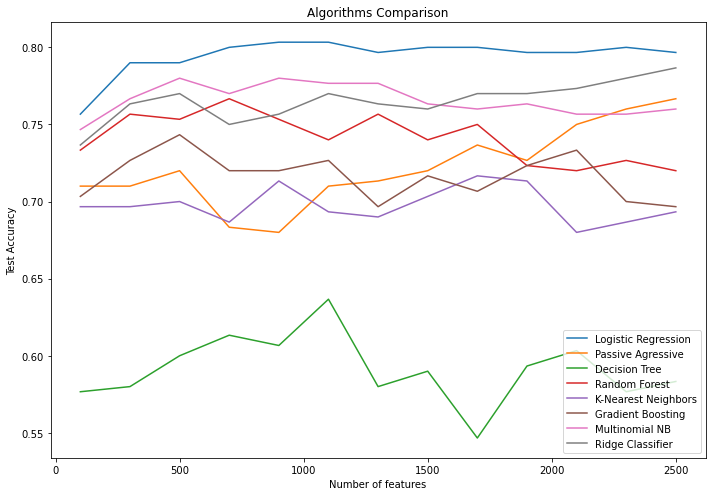

In [39]:
plots_name5 = ['Logistic Regression','Passive Agressive','Decision Tree','Random Forest','K-Nearest Neighbors','Gradient Boosting','Multinomial NB','Ridge Classifier']
plots_list5 = [lr_clf,pa_clf,dt_clf,rf_clf,knn_clf,gb_clf,mnb_clf,rdg_clf]

for n,m in zip(plots_name5,range(len(plots_list5))):
    plots_dict5["df_{}".format(n)] = pd.DataFrame(plots_list5[m]).rename(columns={0:'nfeats',1:'valid_acc'}) 
    plots_dict5["df_{}".format(n)].insert(0,'alg',n)
    
df_plots5 = pd.concat([plots_dict5['df_Logistic Regression'],plots_dict5['df_Passive Agressive'],plots_dict5['df_Decision Tree'],plots_dict5['df_Random Forest'],plots_dict5['df_K-Nearest Neighbors'],plots_dict5['df_Gradient Boosting'],plots_dict5['df_Multinomial NB'],plots_dict5['df_Ridge Classifier']],ignore_index=True)
plt.figure(figsize=(10,7))
sns.lineplot(x='nfeats',y='valid_acc',hue='alg',data=df_plots5)
plt.title("Algorithms Comparison"); plt.legend(loc=4)
plt.xlabel("Number of features"); plt.ylabel("Test Accuracy")
plt.tight_layout();

<br>

***

**Note:** Logistic regression w/ TF-IDF features performed the best out of the other classification algorithms. Moving forward in the modeling notebook, I will continue to hypertune parameters with Logistic Regression and TF-IDF.

*** 

## 8. Save Preprocessed Data

In [40]:
# Save preprocessed data: 'covidvaccine_preprocessed.csv'
# df.to_csv('../data/covidvaccine_preprocessed.csv',index=False)